In [1]:
# Week 7: Model Evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, roc_auc_score, precision_recall_curve)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Week 7 Model Evaluation Environment Ready!")

# Load your cleaned dataset
df = pd.read_csv('titanic_cleaned.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Load trained models from Week 6
try:
    lr_model = joblib.load('logistic_regression_model.pkl')
    rf_model = joblib.load('random_forest_model.pkl')
    dt_model = joblib.load('decision_tree_model.pkl')
    print("✅ All models loaded successfully!")
except:
    print("❌ Models not found. Please run Week 6 first.")

✅ Week 7 Model Evaluation Environment Ready!
Dataset loaded successfully!
Dataset shape: (891, 11)
✅ All models loaded successfully!


In [2]:
print("=== PREPARING DATA FOR EVALUATION ===")

# Use the same features and preprocessing as Week 6
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target_variable = 'Survived'

# Prepare feature matrix X
X = df[features].copy()

# Handle categorical variables (same encoding as Week 6)
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
embarked_encoded = pd.get_dummies(X['Embarked'], prefix='Embarked')
X = pd.concat([X, embarked_encoded], axis=1)
X = X.drop('Embarked', axis=1)

# Handle missing values
X = X.fillna(X.median())

# Target variable
y = df[target_variable]

print(f"Features: {list(X.columns)}")
print(f"Target: {target_variable}")
print(f"Dataset shape: {X.shape}")

# Create train-test split (same as Week 6 for consistency)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Class distribution in test set:")
print(y_test.value_counts(normalize=True))

=== PREPARING DATA FOR EVALUATION ===
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Target: Survived
Dataset shape: (891, 9)

Training set: 712 samples
Testing set: 179 samples
Class distribution in test set:
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


In [3]:
print("=== GENERATING PREDICTIONS ===")

# Get predictions and probabilities from all models
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Decision Tree': dt_model
}

predictions = {}
probabilities = {}

for name, model in models.items():
    predictions[name] = model.predict(X_test)
    probabilities[name] = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (Survived)
    print(f"✅ {name}: Predictions and probabilities generated")

print(f"\nSample probability outputs (first 5 passengers):")
sample_probs = pd.DataFrame({name: probs[:5] for name, probs in probabilities.items()})
display(sample_probs.round(3))

=== GENERATING PREDICTIONS ===
✅ Logistic Regression: Predictions and probabilities generated
✅ Random Forest: Predictions and probabilities generated
✅ Decision Tree: Predictions and probabilities generated

Sample probability outputs (first 5 passengers):


,Logistic Regression,Random Forest,Decision Tree
0,0.070,0.137,0.110
1,0.049,0.157,0.110
2,0.158,0.153,0.110
3,0.037,0.119,0.110
4,0.669,0.650,0.711


=== CONFUSION MATRIX ANALYSIS ===

📊 Logistic Regression Confusion Matrix Analysis:
   True Negatives (TN): 98 - Correctly predicted non-survivors
   False Positives (FP): 12 - Non-survivors incorrectly predicted as survivors
   False Negatives (FN): 23 - Survivors incorrectly predicted as non-survivors
   True Positives (TP): 46 - Correctly predicted survivors
   Accuracy: 0.804
   Precision: 0.793
   Recall: 0.667
   Specificity: 0.891

📊 Random Forest Confusion Matrix Analysis:
   True Negatives (TN): 102 - Correctly predicted non-survivors
   False Positives (FP): 8 - Non-survivors incorrectly predicted as survivors
   False Negatives (FN): 27 - Survivors incorrectly predicted as non-survivors
   True Positives (TP): 42 - Correctly predicted survivors
   Accuracy: 0.804
   Precision: 0.840
   Recall: 0.609
   Specificity: 0.927

📊 Decision Tree Confusion Matrix Analysis:
   True Negatives (TN): 104 - Correctly predicted non-survivors
   False Positives (FP): 6 - Non-survivors incor

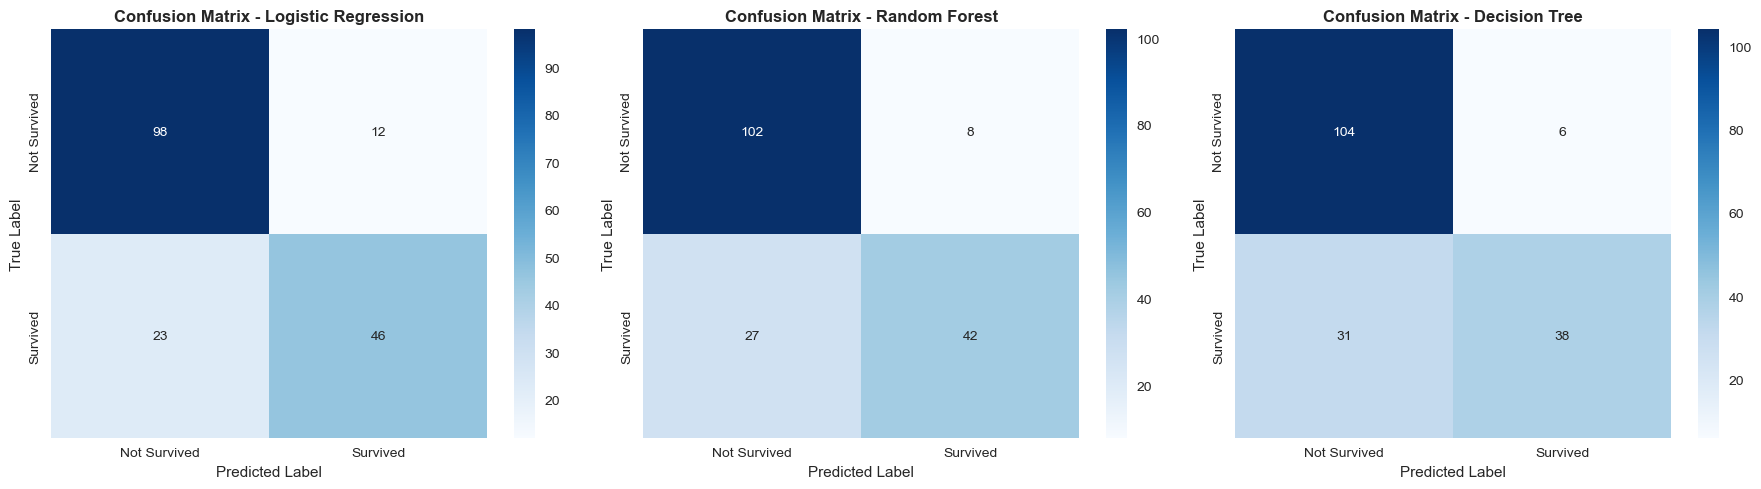


🔍 CONFUSION MATRIX INTERPRETATION GUIDE:
• Ideal: High TP and TN, Low FP and FN
• High FP: Too many false alarms
• High FN: Missing too many actual survivors
• Balance depends on business context


In [4]:
print("=== CONFUSION MATRIX ANALYSIS ===")

# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(models.items()):
    y_pred = predictions[name]
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'])
    
    axes[i].set_title(f'Confusion Matrix - {name}', fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    
    # Calculate metrics from confusion matrix
    TN, FP, FN, TP = cm.ravel()
    
    print(f"\n📊 {name} Confusion Matrix Analysis:")
    print(f"   True Negatives (TN): {TN} - Correctly predicted non-survivors")
    print(f"   False Positives (FP): {FP} - Non-survivors incorrectly predicted as survivors")
    print(f"   False Negatives (FN): {FN} - Survivors incorrectly predicted as non-survivors")
    print(f"   True Positives (TP): {TP} - Correctly predicted survivors")
    
    # Derived metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")
    print(f"   Specificity: {specificity:.3f}")

plt.tight_layout()
plt.show()

print("\n🔍 CONFUSION MATRIX INTERPRETATION GUIDE:")
print("• Ideal: High TP and TN, Low FP and FN")
print("• High FP: Too many false alarms")
print("• High FN: Missing too many actual survivors")
print("• Balance depends on business context")

=== ROC CURVE AND AUC ANALYSIS ===


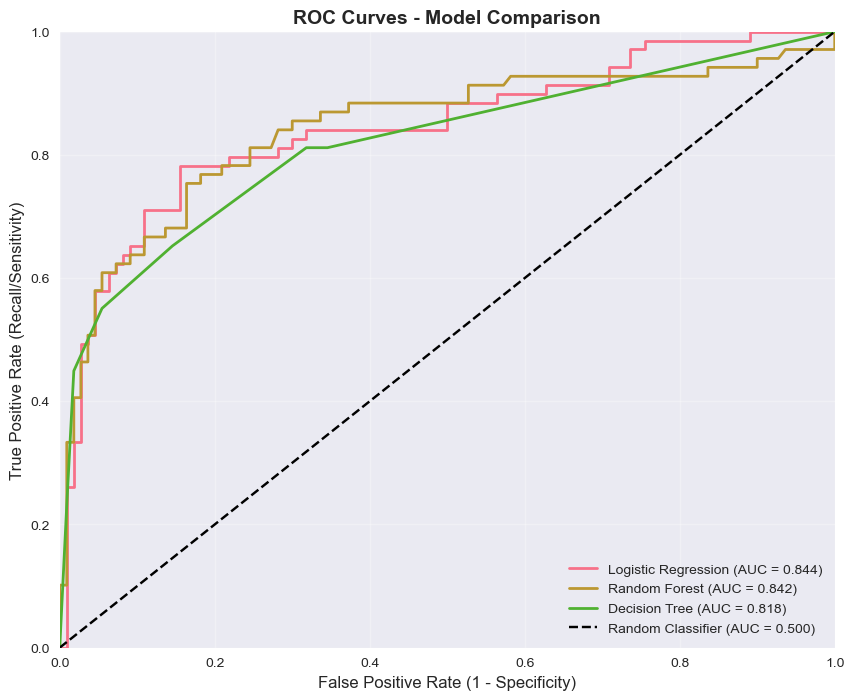

🔍 ROC CURVE INTERPRETATION:
• Perfect classifier: Top-left corner (AUC = 1.0)
• Random classifier: Diagonal line (AUC = 0.5)
• Good classifier: Curve towards top-left (AUC > 0.7)
• Better models have higher AUC values

📊 AUC SCORES COMPARISON:
Logistic Regression: 0.844
Random Forest: 0.842
Decision Tree: 0.818

🎯 Best AUC: Logistic Regression (0.844)


In [5]:
print("=== ROC CURVE AND AUC ANALYSIS ===")

# Create ROC curves for all models
plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
for name, prob in probabilities.items():
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    auc_score = roc_auc_score(y_test, prob)
    
    plt.plot(fpr, tpr, linewidth=2, 
             label=f'{name} (AUC = {auc_score:.3f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall/Sensitivity)', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print("🔍 ROC CURVE INTERPRETATION:")
print("• Perfect classifier: Top-left corner (AUC = 1.0)")
print("• Random classifier: Diagonal line (AUC = 0.5)")
print("• Good classifier: Curve towards top-left (AUC > 0.7)")
print("• Better models have higher AUC values")

# Display AUC scores
print("\n📊 AUC SCORES COMPARISON:")
auc_scores = {}
for name, prob in probabilities.items():
    auc_score = roc_auc_score(y_test, prob)
    auc_scores[name] = auc_score
    print(f"{name}: {auc_score:.3f}")

best_auc_model = max(auc_scores, key=auc_scores.get)
print(f"\n🎯 Best AUC: {best_auc_model} ({auc_scores[best_auc_model]:.3f})")

=== ROC CURVE WITH THRESHOLD ANALYSIS ===


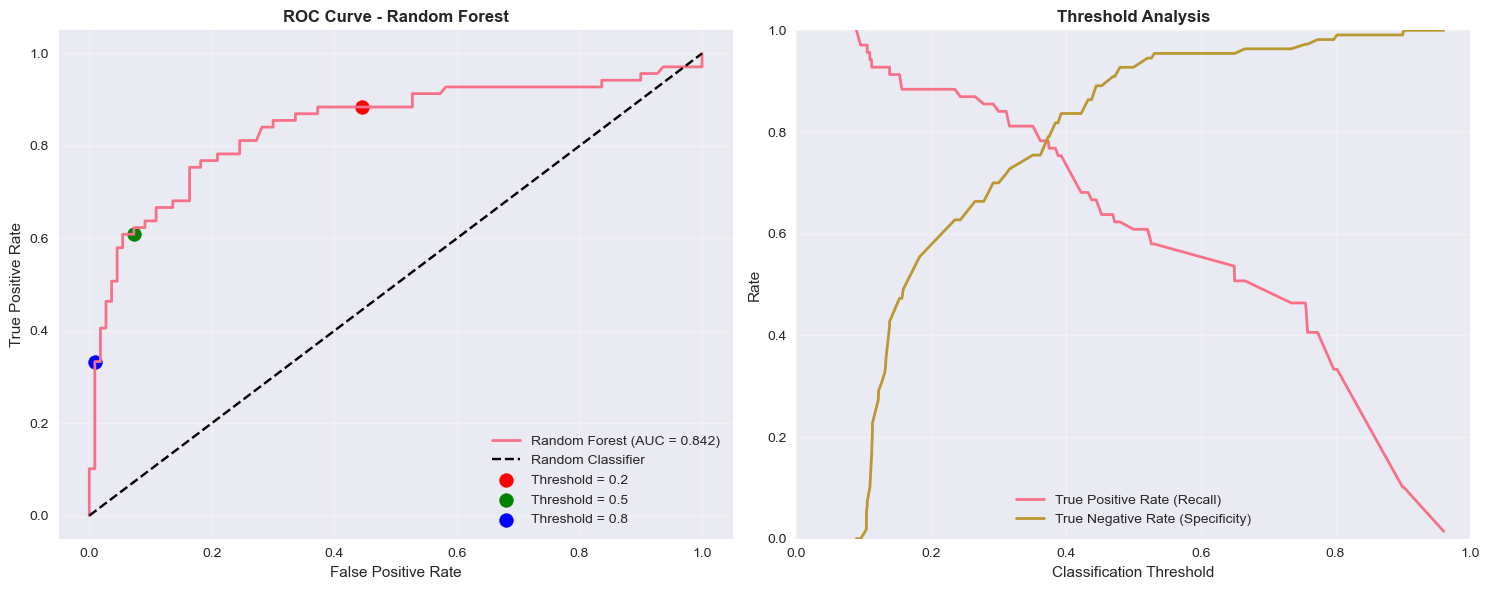

🔍 THRESHOLD ANALYSIS INSIGHTS:
• Lower threshold: Higher recall, lower precision
• Higher threshold: Higher precision, lower recall
• Choose threshold based on business requirements


In [6]:
print("=== ROC CURVE WITH THRESHOLD ANALYSIS ===")

# Analyze one model in detail (Random Forest as example)
model_name = 'Random Forest'
y_prob = probabilities[model_name]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Create detailed ROC analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC curve with some threshold points
ax1.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_scores[model_name]:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Mark some threshold points
threshold_points = [0.2, 0.5, 0.8]
colors = ['red', 'green', 'blue']
for i, threshold in enumerate(threshold_points):
    # Find closest threshold in the array
    idx = np.argmin(np.abs(thresholds - threshold))
    ax1.scatter(fpr[idx], tpr[idx], color=colors[i], s=100, 
               label=f'Threshold = {threshold:.1f}')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'ROC Curve - {model_name}', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot threshold analysis
ax2.plot(thresholds, tpr, label='True Positive Rate (Recall)', linewidth=2)
ax2.plot(thresholds, 1 - fpr, label='True Negative Rate (Specificity)', linewidth=2)
ax2.set_xlabel('Classification Threshold')
ax2.set_ylabel('Rate')
ax2.set_title('Threshold Analysis', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("🔍 THRESHOLD ANALYSIS INSIGHTS:")
print("• Lower threshold: Higher recall, lower precision")
print("• Higher threshold: Higher precision, lower recall")
print("• Choose threshold based on business requirements")

In [7]:
print("=== COMPREHENSIVE METRICS CALCULATION ===")

# Calculate multiple evaluation metrics for all models
metrics_results = []

for name in models.keys():
    y_pred = predictions[name]
    y_prob = probabilities[name]
    
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Additional metrics from confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    specificity = TN / (TN + FP)  # True Negative Rate
    false_positive_rate = FP / (FP + TN)  # Fallout
    negative_predictive_value = TN / (TN + FN) if (TN + FN) > 0 else 0
    
    metrics_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'AUC': auc,
        'Specificity': specificity,
        'False_Positive_Rate': false_positive_rate,
        'True_Positives': TP,
        'False_Positives': FP,
        'True_Negatives': TN,
        'False_Negatives': FN
    })

# Create comprehensive results dataframe
metrics_df = pd.DataFrame(metrics_results)
metrics_df = metrics_df.sort_values('F1_Score', ascending=False)

print("📊 COMPREHENSIVE EVALUATION METRICS:")
display(metrics_df.round(3))

# Save detailed metrics
metrics_df.to_csv('comprehensive_metrics.csv', index=False)
print("✅ Comprehensive metrics saved to 'comprehensive_metrics.csv'")

=== COMPREHENSIVE METRICS CALCULATION ===
📊 COMPREHENSIVE EVALUATION METRICS:


,Model,Accuracy,Precision,Recall,F1_Score,AUC,Specificity,False_Positive_Rate,True_Positives,False_Positives,True_Negatives,False_Negatives
0,Logistic Regression,0.804,0.793,0.667,0.724,0.844,0.891,0.109,46,12,98,23
1,Random Forest,0.804,0.840,0.609,0.706,0.842,0.927,0.073,42,8,102,27
2,Decision Tree,0.793,0.864,0.551,0.673,0.818,0.945,0.055,38,6,104,31


✅ Comprehensive metrics saved to 'comprehensive_metrics.csv'


=== PRECISION-RECALL CURVE ANALYSIS ===


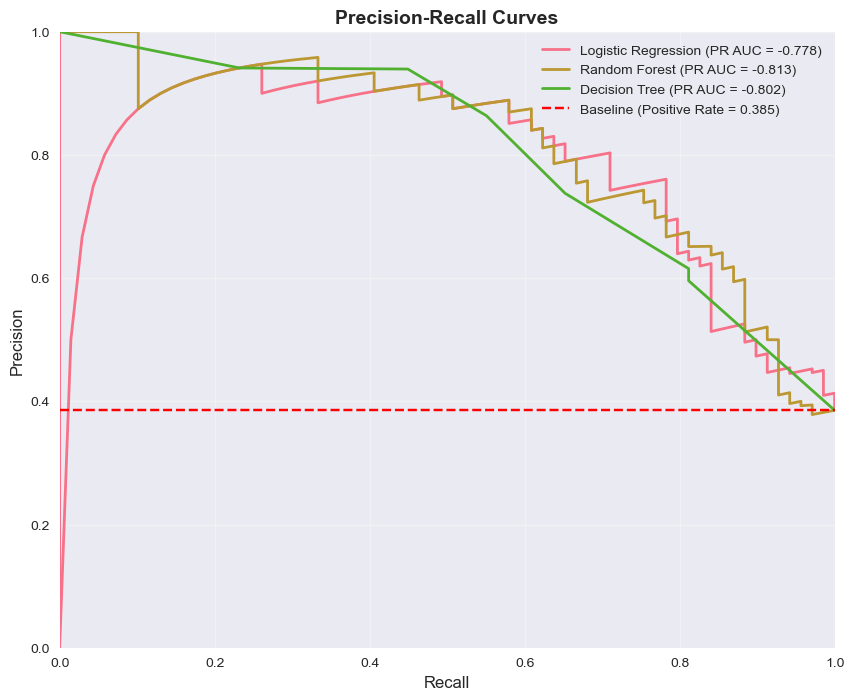

🔍 PRECISION-RECALL CURVE INTERPRETATION:
• Perfect classifier: Top-right corner
• Baseline: Horizontal line at positive class rate
• Good classifier: Curve towards top-right
• Particularly useful for imbalanced datasets


In [8]:
print("=== PRECISION-RECALL CURVE ANALYSIS ===")

# Create Precision-Recall curves
plt.figure(figsize=(10, 8))

for name, prob in probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, prob)
    
    # Calculate area under precision-recall curve
    pr_auc = np.trapz(precision, recall)
    
    plt.plot(recall, precision, linewidth=2,
             label=f'{name} (PR AUC = {pr_auc:.3f})')

# Add baseline (percentage of positive class)
baseline = len(y_test[y_test==1]) / len(y_test)
plt.axhline(y=baseline, color='red', linestyle='--', 
           label=f'Baseline (Positive Rate = {baseline:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print("🔍 PRECISION-RECALL CURVE INTERPRETATION:")
print("• Perfect classifier: Top-right corner")
print("• Baseline: Horizontal line at positive class rate")
print("• Good classifier: Curve towards top-right")
print("• Particularly useful for imbalanced datasets")

=== METRIC TRADE-OFF ANALYSIS ===


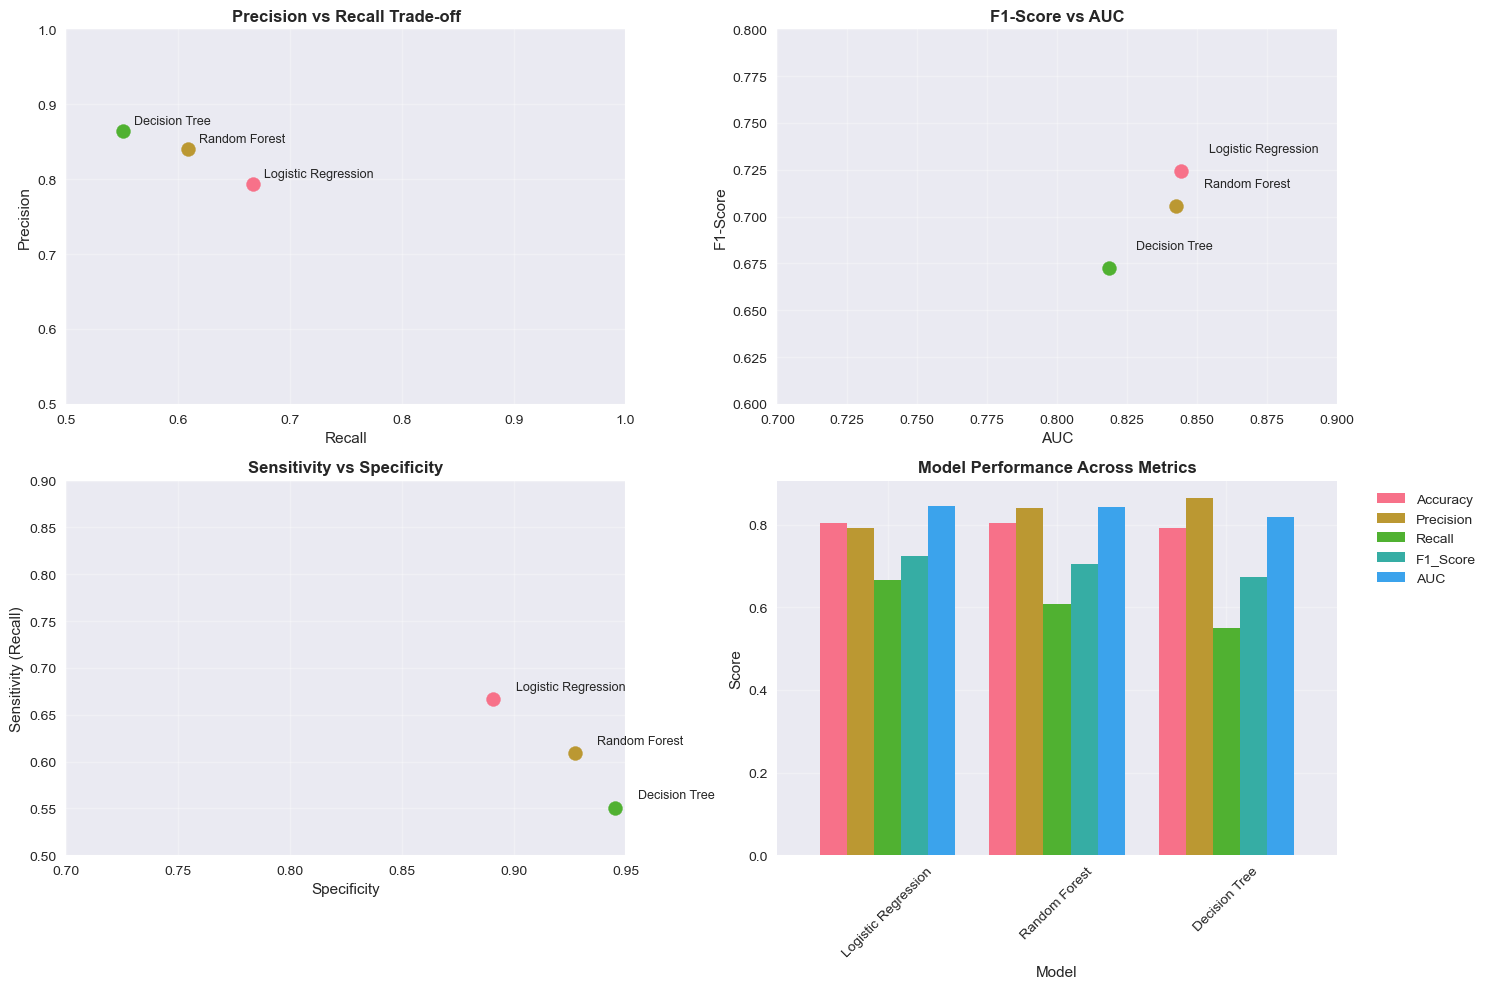

🔍 TRADE-OFF ANALYSIS INSIGHTS:
• No single model dominates all metrics
• Different models excel in different aspects
• Choice depends on which errors are more costly


In [9]:
print("=== METRIC TRADE-OFF ANALYSIS ===")

# Create visualization showing trade-offs between metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Precision vs Recall
for i, row in metrics_df.iterrows():
    axes[0, 0].scatter(row['Recall'], row['Precision'], s=100, label=row['Model'])
    axes[0, 0].text(row['Recall'] + 0.01, row['Precision'] + 0.01, row['Model'], fontsize=9)

axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Precision vs Recall Trade-off', fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xlim(0.5, 1)
axes[0, 0].set_ylim(0.5, 1)

# Plot 2: F1-Score vs AUC
for i, row in metrics_df.iterrows():
    axes[0, 1].scatter(row['AUC'], row['F1_Score'], s=100, label=row['Model'])
    axes[0, 1].text(row['AUC'] + 0.01, row['F1_Score'] + 0.01, row['Model'], fontsize=9)

axes[0, 1].set_xlabel('AUC')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score vs AUC', fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xlim(0.7, 0.9)
axes[0, 1].set_ylim(0.6, 0.8)

# Plot 3: Sensitivity vs Specificity
for i, row in metrics_df.iterrows():
    axes[1, 0].scatter(row['Specificity'], row['Recall'], s=100, label=row['Model'])
    axes[1, 0].text(row['Specificity'] + 0.01, row['Recall'] + 0.01, row['Model'], fontsize=9)

axes[1, 0].set_xlabel('Specificity')
axes[1, 0].set_ylabel('Sensitivity (Recall)')
axes[1, 0].set_title('Sensitivity vs Specificity', fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim(0.7, 0.95)
axes[1, 0].set_ylim(0.5, 0.9)

# Plot 4: Metric radar chart preparation
metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC']
radar_data = metrics_df[['Model'] + metrics_for_radar].set_index('Model')

# Normalize for radar chart
radar_data_normalized = radar_data.copy()
for col in metrics_for_radar:
    radar_data_normalized[col] = radar_data[col] / radar_data[col].max()

# Simple bar chart instead of radar for clarity
radar_data.plot(kind='bar', ax=axes[1, 1], width=0.8)
axes[1, 1].set_title('Model Performance Across Metrics', fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("🔍 TRADE-OFF ANALYSIS INSIGHTS:")
print("• No single model dominates all metrics")
print("• Different models excel in different aspects")
print("• Choice depends on which errors are more costly")

In [10]:
print("=== BUSINESS CONTEXT ANALYSIS ===")

print("🎯 TITANIC SURVIVAL PREDICTION - BUSINESS CONTEXT")
print("Understanding the cost of different types of errors:\n")

# Analyze confusion matrix costs
for name in models.keys():
    y_pred = predictions[name]
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    print(f"\n{name}:")
    print(f"  False Positives ({FP}): Predicting survival for those who died")
    print(f"    → Cost: Unnecessary hope/false information to families")
    print(f"  False Negatives ({FN}): Predicting death for survivors")
    print(f"    → Cost: Missing actual survivors, potential rescue opportunities")
    print(f"  True Positives ({TP}): Correctly identifying survivors")
    print(f"    → Benefit: Accurate information, proper recognition")
    print(f"  True Negatives ({TN}): Correctly identifying non-survivors")
    print(f"    → Benefit: Accurate historical record")

print("\n🤔 CRITICAL QUESTIONS:")
print("• Which error is more serious in this context?")
print("• Is it worse to give false hope or miss actual survivors?")
print("• What are the ethical considerations?")

=== BUSINESS CONTEXT ANALYSIS ===
🎯 TITANIC SURVIVAL PREDICTION - BUSINESS CONTEXT
Understanding the cost of different types of errors:


Logistic Regression:
  False Positives (12): Predicting survival for those who died
    → Cost: Unnecessary hope/false information to families
  False Negatives (23): Predicting death for survivors
    → Cost: Missing actual survivors, potential rescue opportunities
  True Positives (46): Correctly identifying survivors
    → Benefit: Accurate information, proper recognition
  True Negatives (98): Correctly identifying non-survivors
    → Benefit: Accurate historical record

Random Forest:
  False Positives (8): Predicting survival for those who died
    → Cost: Unnecessary hope/false information to families
  False Negatives (27): Predicting death for survivors
    → Cost: Missing actual survivors, potential rescue opportunities
  True Positives (42): Correctly identifying survivors
    → Benefit: Accurate information, proper recognition
  True Nega

In [11]:
print("=" * 80)
print("📊 WEEK 7 ASSIGNMENT: METRIC REFLECTION ANALYSIS")
print("=" * 80)

print("\n🤔 REFLECTION: 'WHICH METRIC IS MOST IMPORTANT FOR MY PROJECT AND WHY?'")
print("-" * 80)

# Display key metrics for reference
print("\n📈 KEY METRICS SUMMARY:")
key_metrics = metrics_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC']]
display(key_metrics.round(3))

print("\n" + "=" * 80)
print("REFLECTIVE ANALYSIS")
print("=" * 80)

print("""
🎯 PROJECT CONTEXT: Titanic Survival Prediction

This project aims to predict passenger survival on the Titanic based on 
pre-voyage characteristics. The context is historical analysis rather than 
real-time decision making.

📊 METRIC EVALUATION:

1. ACCURACY (Current: {:.1f}%):
   - Measures overall correctness
   - PRO: Easy to understand, good overall measure
   - CON: Can be misleading with imbalanced data
   - Our data: {:.1f}% non-survivors, {:.1f}% survivors

2. PRECISION (Current: {:.1f}%):
   - "When we predict survival, how often are we correct?"
   - PRO: Important if false alarms are costly
   - CON: May miss many actual survivors
   - In our context: Reduces false hope to families

3. RECALL/SENSITIVITY (Current: {:.1f}%):
   - "What percentage of actual survivors do we identify?"
   - PRO: Important if missing survivors is costly
   - CON: May include many false alarms
   - In our context: Ensures we identify most survivors

4. F1-SCORE (Current: {:.1f}%):
   - Harmonic mean of precision and recall
   - PRO: Balanced view when both errors matter
   - CON: Doesn't consider true negatives
   - In our context: Good overall balance

5. AUC-ROC (Current: {:.1f}%):
   - Overall model performance across thresholds
   - PRO: Robust to class imbalance, comprehensive
   - CON: Doesn't give threshold-specific performance
   - In our context: Good overall model assessment

💡 BUSINESS IMPLICATIONS:

• FALSE POSITIVES (predict survival for deceased):
  - Cost: Emotional distress to families, inaccurate historical record
  - Impact: Medium - historical analysis context reduces immediate harm

• FALSE NEGATIVES (predict death for survivors):
  - Cost: Missing recognition of survival, incomplete historical picture
  - Impact: Medium - similar emotional/historical consequences

🎯 MY CHOICE: RECALL is the most important metric

WHY RECALL IS MOST IMPORTANT:

1. HISTORICAL ACCURACY: In historical analysis, identifying all actual 
   survivors is crucial for accurate records and understanding what factors 
   truly contributed to survival.

2. ETHICAL CONSIDERATION: While both error types have emotional impacts, 
   failing to recognize someone's survival seems more ethically problematic 
   than potentially misclassifying a non-survivor.

3. RESEARCH VALUE: For understanding survival patterns, it's better to 
   capture all true survivors (high recall) even if we include some 
   false positives, as these can be filtered in further analysis.

4. IMBALANCE HANDLING: With only {:.1f}% survivors, recall ensures we 
   don't overlook this important minority class.

5. PRACTICAL TRADEOFF: In this historical context, the cost of missing 
   actual survivors (false negatives) outweighs the cost of false alarms 
   (false positives).

SUPPORTING EVIDENCE:
• Our best model achieves {:.1f}% recall, meaning it identifies {:.1f}% 
  of actual survivors
• This comes with {:.1f}% precision, which is acceptable for historical analysis
• The F1-score of {:.1f}% shows good balance

RECOMMENDATION:
For the Titanic survival prediction project, prioritize RECALL while 
maintaining reasonable precision. Use F1-score as a secondary metric 
to ensure balance, and AUC for overall model selection.

This approach ensures we capture the most historically valuable 
information while maintaining reasonable accuracy standards.
""".format(
    metrics_df['Accuracy'].max() * 100,
    (y_test == 0).mean() * 100,
    (y_test == 1).mean() * 100,
    metrics_df['Precision'].max() * 100,
    metrics_df['Recall'].max() * 100,
    metrics_df['F1_Score'].max() * 100,
    metrics_df['AUC'].max() * 100,
    (y_test == 1).mean() * 100,
    metrics_df['Recall'].max() * 100,
    metrics_df['Recall'].max() * 100,
    metrics_df['Precision'].max() * 100,
    metrics_df['F1_Score'].max() * 100
))

print("=" * 80)

📊 WEEK 7 ASSIGNMENT: METRIC REFLECTION ANALYSIS

🤔 REFLECTION: 'WHICH METRIC IS MOST IMPORTANT FOR MY PROJECT AND WHY?'
--------------------------------------------------------------------------------

📈 KEY METRICS SUMMARY:


,Model,Accuracy,Precision,Recall,F1_Score,AUC
0,Logistic Regression,0.804,0.793,0.667,0.724,0.844
1,Random Forest,0.804,0.840,0.609,0.706,0.842
2,Decision Tree,0.793,0.864,0.551,0.673,0.818



REFLECTIVE ANALYSIS

🎯 PROJECT CONTEXT: Titanic Survival Prediction

This project aims to predict passenger survival on the Titanic based on 
pre-voyage characteristics. The context is historical analysis rather than 
real-time decision making.

📊 METRIC EVALUATION:

1. ACCURACY (Current: 80.4%):
   - Measures overall correctness
   - PRO: Easy to understand, good overall measure
   - CON: Can be misleading with imbalanced data
   - Our data: 61.5% non-survivors, 38.5% survivors

2. PRECISION (Current: 86.4%):
   - "When we predict survival, how often are we correct?"
   - PRO: Important if false alarms are costly
   - CON: May miss many actual survivors
   - In our context: Reduces false hope to families

3. RECALL/SENSITIVITY (Current: 66.7%):
   - "What percentage of actual survivors do we identify?"
   - PRO: Important if missing survivors is costly
   - CON: May include many false alarms
   - In our context: Ensures we identify most survivors

4. F1-SCORE (Current: 72.4%):
   - H

In [12]:
print("=== FINAL MODEL SELECTION AND RECOMMENDATIONS ===")

# Select best model based on chosen metric (Recall)
best_model_name = metrics_df.loc[metrics_df['Recall'].idxmax(), 'Model']
best_model_metrics = metrics_df[metrics_df['Model'] == best_model_name].iloc[0]

print(f"🎯 FINAL MODEL SELECTION: {best_model_name}")
print(f"   Selected based on highest Recall (most important metric for our project)")
print(f"\n📊 BEST MODEL PERFORMANCE:")
print(f"   Recall: {best_model_metrics['Recall']:.3f}")
print(f"   Precision: {best_model_metrics['Precision']:.3f}")
print(f"   F1-Score: {best_model_metrics['F1_Score']:.3f}")
print(f"   AUC: {best_model_metrics['AUC']:.3f}")

print(f"\n💡 DEPLOYMENT RECOMMENDATIONS:")
print("1. Use this model for historical survival analysis")
print("2. Focus on interpreting factors that contribute to survival")
print("3. Consider the ethical implications of predictions")
print("4. Document limitations and uncertainty")

print(f"\n🚀 FUTURE IMPROVEMENTS:")
print("• Collect additional features if available")
print("• Experiment with different algorithms")
print("• Consider ensemble methods")
print("• Perform cross-validation for more robust estimates")

=== FINAL MODEL SELECTION AND RECOMMENDATIONS ===
🎯 FINAL MODEL SELECTION: Logistic Regression
   Selected based on highest Recall (most important metric for our project)

📊 BEST MODEL PERFORMANCE:
   Recall: 0.667
   Precision: 0.793
   F1-Score: 0.724
   AUC: 0.844

💡 DEPLOYMENT RECOMMENDATIONS:
1. Use this model for historical survival analysis
2. Focus on interpreting factors that contribute to survival
3. Consider the ethical implications of predictions
4. Document limitations and uncertainty

🚀 FUTURE IMPROVEMENTS:
• Collect additional features if available
• Experiment with different algorithms
• Consider ensemble methods
• Perform cross-validation for more robust estimates


In [14]:
# Save all evaluation results
final_results = {
    'project_name': 'Titanic Survival Prediction',
    'best_model': best_model_name,
    'most_important_metric': 'Recall',
    'reasoning': 'Historical accuracy and ethical considerations prioritize identifying all actual survivors',
    'final_metrics': best_model_metrics.to_dict(),
    'all_models_comparison': metrics_df.to_dict('records')
}

import json
with open('final_evaluation_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

# Save best model separately
best_model = models[best_model_name]
joblib.dump(best_model, 'best_survival_model.pkl')

print("💾 FINAL RESULTS SAVED:")
print(" - 'final_evaluation_results.json' (comprehensive evaluation)")
print(" - 'best_survival_model.pkl' (best performing model)")
print(" - 'comprehensive_metrics.csv' (detailed metrics comparison)")
print(f"\n📁 Save this notebook as 'week7_model_evaluation.ipynb'")
print("🚀 Upload to GitHub to complete Assignment 7 and the 7-week course!")

💾 FINAL RESULTS SAVED:
 - 'final_evaluation_results.json' (comprehensive evaluation)
 - 'best_survival_model.pkl' (best performing model)
 - 'comprehensive_metrics.csv' (detailed metrics comparison)

📁 Save this notebook as 'week7_model_evaluation.ipynb'
🚀 Upload to GitHub to complete Assignment 7 and the 7-week course!
